In [1]:
#%pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## 1. EDA (Exploratory Data Analysis)

In [3]:
# Configuració visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Càrrega de dades
# Assegura't que el fitxer 'trs_train.csv' està al mateix directori
df = pd.read_csv('trs_train.csv')

print(f"Dimensions del dataset: {df.shape}")
display(df.head())

Dimensions del dataset: (9000, 28)


,patient_id,Age,Sex,Ethnicity,Duration_untreated_psychosis,Family_history,Initial_response,Lymphocyte_count,Neutrophil_count,BMI,...,Polygenic_risk_score,Del_22q11_2_status,IL_17A,CCL23,TWEAK,Ki_whole_striatum,Ki_associative_striatum,SUVRc_whole_striatum,SUVRc_associative_striatum,TRS
0,1,28.0,1,Caucasian,7.5,1,24.7,2.35,NaN,31.2,...,0.330,0,2.76,5.66,4.47,0.01147,0.01082,1.225,1.133,0
1,2,23.0,1,Asian,3.6,1,41.0,2.02,3.34,26.2,...,0.121,0,2.04,2.67,1.93,0.01386,0.01437,1.042,1.502,0
2,3,29.0,1,Caucasian,7.4,0,6.0,NaN,5.38,39.2,...,-0.098,0,1.55,2.31,2.92,0.01589,0.01632,1.728,1.842,0
3,4,36.0,0,Hispanic,5.5,0,43.4,1.60,6.84,31.5,...,0.019,0,1.77,2.37,4.26,0.01178,0.01154,1.399,1.249,0
4,5,23.0,0,Caucasian,4.5,0,86.1,NaN,3.18,29.6,...,-0.049,0,2.11,3.55,3.84,0.01209,0.01171,0.800,1.533,0


## 1.1 Anàlisi estadístic bàsic
Generem taula descriptiva amb estadístiques bàsiques i taxa de valors perduts per a cada variable. 

Balanceig de la classe objectiu (TRS).

També missing vaules.

Outliers

In [4]:
stats_desc = df.describe().T
stats_desc['missing_rate'] = df.isnull().mean()
print("Estadístiques descriptives:")
display(stats_desc)

Estadístiques descriptives:


,count,mean,std,min,25%,50%,75%,max,missing_rate
patient_id,9000.0,4500.500000,2598.220545,1.00000,2250.75000,4500.50000,6750.25000,9000.000,0.000000
Age,9000.0,26.039444,10.011767,13.00000,19.00000,25.00000,31.00000,64.000,0.000000
Sex,9000.0,0.576000,0.494218,0.00000,0.00000,1.00000,1.00000,1.000,0.000000
Duration_untreated_psychosis,8872.0,19.220548,19.545745,0.30000,6.40000,12.50000,24.30000,125.000,0.014222
Family_history,9000.0,0.118778,0.323545,0.00000,0.00000,0.00000,0.00000,1.000,0.000000
Initial_response,9000.0,41.840367,30.160230,0.00000,10.10000,38.20000,72.30000,100.000,0.000000
Lymphocyte_count,7009.0,1.795761,0.601099,0.50000,1.38000,1.80000,2.20000,4.020,0.221222
Neutrophil_count,7015.0,5.014574,1.471581,1.50000,4.00500,5.02000,6.01000,9.960,0.220556
BMI,9000.0,28.107556,5.433100,15.00000,24.40000,28.00000,31.70000,49.600,0.000000
Triglycerides,6547.0,152.012800,61.099018,40.00000,108.05000,151.10000,194.60000,394.600,0.272556


C:\Users\User\AppData\Local\Temp\ipykernel_15704\795362489.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TRS', data=df, palette='viridis')


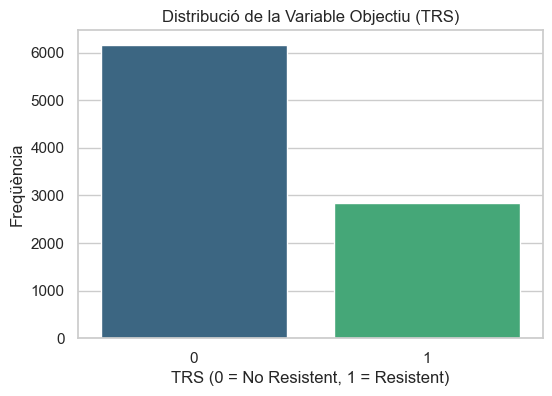

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(x='TRS', data=df, palette='viridis')
plt.title('Distribució de la Variable Objectiu (TRS)')
plt.xlabel('TRS (0 = No Resistent, 1 = Resistent)')
plt.ylabel('Freqüència')
plt.show()


In [7]:
ratio_trs = df['TRS'].value_counts(normalize=True)
print(f"Ratio de classes:\n{ratio_trs}")

Ratio de classes:
TRS
0    0.684667
1    0.315333
Name: proportion, dtype: float64


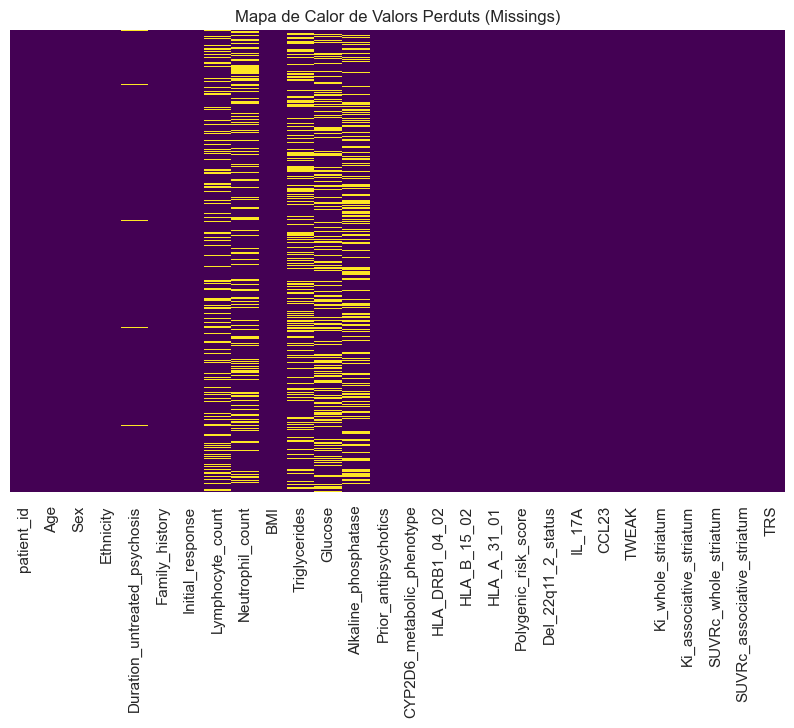

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Mapa de Calor de Valors Perduts (Missings)')
plt.show()

In [9]:
cols_with_missing = df.columns[df.isnull().any()].tolist()
print(f"Variables amb missings: {cols_with_missing}")

Variables amb missings: ['Duration_untreated_psychosis', 'Lymphocyte_count', 'Neutrophil_count', 'Triglycerides', 'Glucose', 'Alkaline_phosphatase', 'Polygenic_risk_score', 'IL_17A']


Variables analitzades (contínues): 19
Variables excloses (binàries/constants): ['HLA_B_15_02', 'HLA_A_31_01', 'Del_22q11_2_status', 'Sex', 'TRS', 'HLA_DRB1_04_02', 'Family_history']

--- RESUM D'OUTLIERS DETECTATS (Només Variables Contínues) ---


,count,percent,min_outlier,max_outlier,lower_limit,upper_limit
Duration_untreated_psychosis,651.0,7.23,51.3000,125.000,-20.4500,51.1500
Age,360.0,4.00,50.0000,64.000,1.0000,49.0000
Polygenic_risk_score,125.0,1.39,-0.4370,0.575,-0.3385,0.3855
Ki_associative_striatum,83.0,0.92,0.0195,0.021,0.0063,0.0195
Ki_whole_striatum,71.0,0.79,0.0193,0.020,0.0065,0.0193
CCL23,59.0,0.66,-0.2000,7.690,0.9650,6.6050
TWEAK,58.0,0.64,-0.5400,8.920,0.8650,7.5450
IL_17A,57.0,0.63,-0.2000,5.380,0.4850,4.8450
BMI,39.0,0.43,42.7000,49.600,13.4500,42.6500
SUVRc_whole_striatum,35.0,0.39,1.9510,2.000,0.3860,1.9460


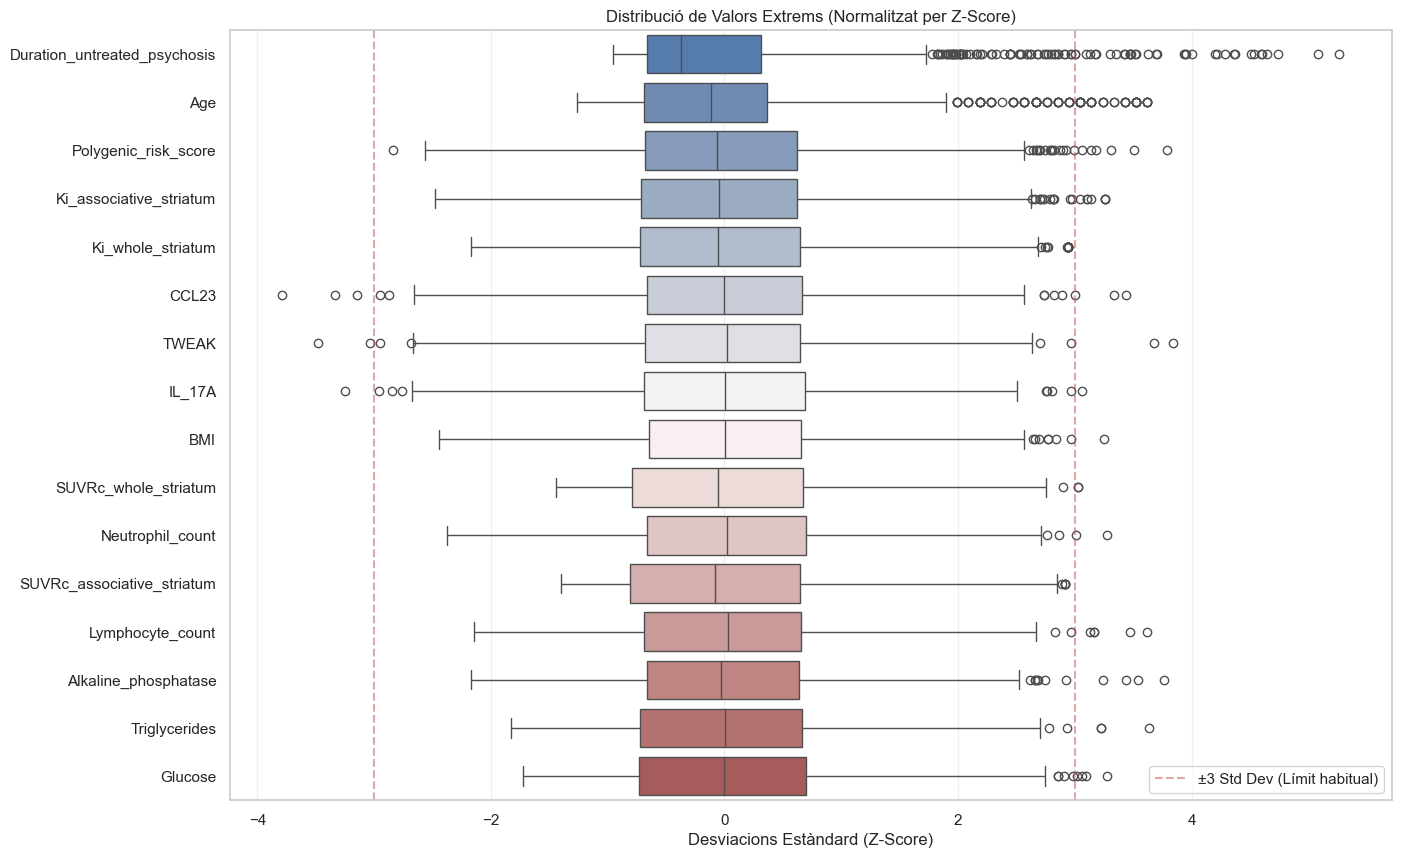

In [12]:
# 1. Identificació intel·ligent de variables numèriques NO binàries
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Filtrem: Ens quedem només amb les columnes que tenen més de 2 valors únics
# Això elimina automàticament 'TRS', 'Sex', 'Family_history', etc.
continuous_cols = [col for col in numeric_cols if df[col].nunique() > 2]

print(f"Variables analitzades (contínues): {len(continuous_cols)}")
print(f"Variables excloses (binàries/constants): {list(set(numeric_cols) - set(continuous_cols))}\n")

# Diccionari per guardar els resultats
outliers_summary = {}

for col in continuous_cols:
    # Calculem IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definim els límits
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifiquem els valors fora dels límits
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    
    # Guardem si n'hi ha
    if len(outliers) > 0:
        outliers_summary[col] = {
            'count': len(outliers),
            'percent': round((len(outliers) / len(df)) * 100, 2),
            'min_outlier': round(outliers.min(), 4),
            'max_outlier': round(outliers.max(), 4),
            'lower_limit': round(lower_bound, 4),
            'upper_limit': round(upper_bound, 4)
        }

# 2. Taula Resum
if outliers_summary:
    outliers_df = pd.DataFrame(outliers_summary).T.sort_values('percent', ascending=False)
    print("--- RESUM D'OUTLIERS DETECTATS (Només Variables Contínues) ---")
    display(outliers_df)
else:
    print("No s'han detectat outliers significatius amb el mètode IQR.")

# 3. Visualització Global (Només de les contínues amb outliers)
if outliers_summary:
    cols_with_outliers = outliers_df.index.tolist()
    
    plt.figure(figsize=(15, len(cols_with_outliers) * 0.5 + 2)) # Ajusta l'alçada segons nº variables
    
    # Estandarditzem per fer-les comparables al gràfic
    df_plot = df[cols_with_outliers].dropna() # Eliminem NaNs només pel plot
    df_std = (df_plot - df_plot.mean()) / df_plot.std()
    
    sns.boxplot(data=df_std, orient='h', palette="vlag")
    plt.title('Distribució de Valors Extrems (Normalitzat per Z-Score)')
    plt.xlabel('Desviacions Estàndard (Z-Score)')
    plt.axvline(x=3, color='r', linestyle='--', alpha=0.5, label='±3 Std Dev (Límit habitual)')
    plt.axvline(x=-3, color='r', linestyle='--', alpha=0.5)
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.show()


correlació i pca

In [13]:
# 1. Separem la variable objectiu (no entra al PCA ni sol entrar a la correlació de features)
X_full = df.drop('TRS', axis=1)

# 2. Definim les columnes
numeric_features = X_full.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_full.select_dtypes(include=['object', 'category']).columns.tolist()

# 3. Pipeline de transformació (el necessites per convertir text a números i omplir buits)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # O 'mean'
    ('scaler', StandardScaler()) # PCA requereix dades escalades
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False per facilitar visualització
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    verbose_feature_names_out=False # Per tenir noms de columnes més nets
)

# 4. Apliquem la transformació a TOT el dataset
X_full_processed = preprocessor.fit_transform(X_full)

# 5. Recuperem els noms per poder fer el gràfic de correlació maco
feature_names = preprocessor.get_feature_names_out()
X_full_df = pd.DataFrame(X_full_processed, columns=feature_names)

print("Dades preparades per a l'anàlisi global.")


Dades preparades per a l'anàlisi global.


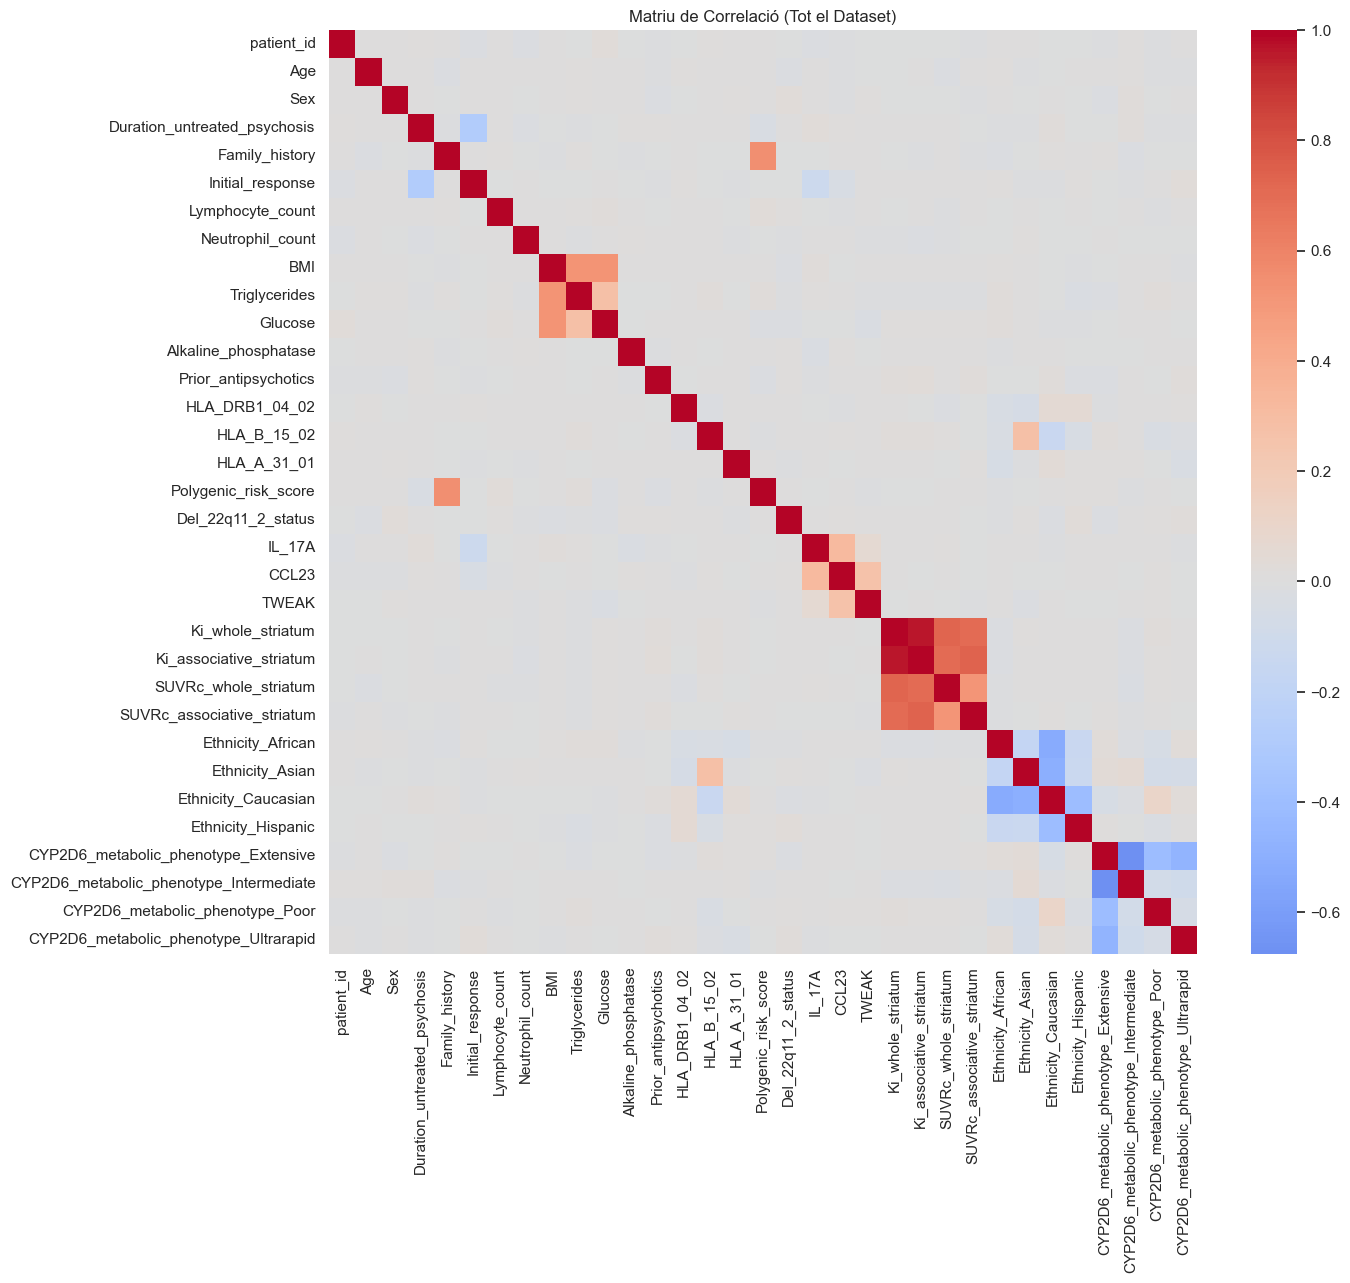

Parells de variables altament correlacionades: [('Ki_whole_striatum', 'Ki_associative_striatum')]


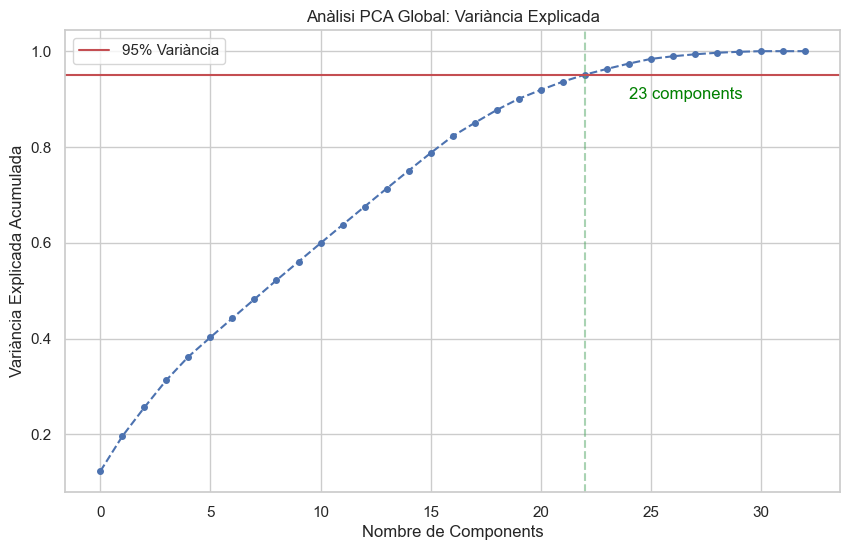

Nombre de components necessaris per explicar el 95% de la variància: 23


In [14]:
# --- 5.1 Matriu de Correlació (Global) ---
plt.figure(figsize=(14, 12))
# Calculem correlació
corr_matrix = X_full_df.corr()

# Dibuixem el heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, center=0)
plt.title('Matriu de Correlació (Tot el Dataset)')
plt.show()

# Identificar parells amb alta correlació (> 0.9 o < -0.9)
high_corr_var = np.where(np.abs(corr_matrix) > 0.9)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                 for x, y in zip(*high_corr_var) if x != y and x < y]
print(f"Parells de variables altament correlacionades: {high_corr_var}")


# --- 5.2 Anàlisi de Dimensionalitat amb PCA (Global) ---
pca = PCA()
pca.fit(X_full_processed) # Usem la matriu numpy directament

# Gràfic de variància explicada acumulada
plt.figure(figsize=(10, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance, marker='o', linestyle='--', markersize=4)

plt.xlabel('Nombre de Components')
plt.ylabel('Variància Explicada Acumulada')
plt.title('Anàlisi PCA Global: Variància Explicada')
plt.grid(True)

# Línia del 95%
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variància')
plt.legend()

# Busquem el punt exacte
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
plt.axvline(x=n_components_95 - 1, color='g', linestyle='--', alpha=0.5) # -1 per ajustar índex 0
plt.text(n_components_95 + 1, 0.90, f'{n_components_95} components', color='green')

plt.show()

print(f"Nombre de components necessaris per explicar el 95% de la variància: {n_components_95}")
